In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapely.geometry as sgeom
import metpy.calc as mpcalc

plt.rcParams['font.sans-serif'] = ['SimHei']  ###防止无法显示中文并设置黑体
plt.rcParams['axes.unicode_minus'] = False  ###用来正常显示负号

In [2]:
import salem as sl
ds=sl.open_wrf_dataset('20220330guangdongraindata/wrfout_d02_2021-03-30_06_00_00')
ds

FileNotFoundError: [Errno 2] No such file or directory: b'20220330guangdongraindata/wrfout_d02_2021-03-30_06_00_00'

In [ ]:
# hgt
hgt500=ds.salem.wrf_plevel('GEOPOTENTIAL',levels=500)/100
hgt850=ds.salem.wrf_plevel('GEOPOTENTIAL',levels=850)/100
hgt925=ds.salem.wrf_plevel('GEOPOTENTIAL',levels=925)/100
# u
u500=ds.salem.wrf_plevel('U',levels=500)
u850=ds.salem.wrf_plevel('U',levels=850)
u925=ds.salem.wrf_plevel('U',levels=925)
# v
v500=ds.salem.wrf_plevel('V',levels=500)
v850=ds.salem.wrf_plevel('V',levels=850)
v925=ds.salem.wrf_plevel('V',levels=925)
# q
q500=ds.salem.wrf_plevel('QVAPOR',levels=500)
q850=ds.salem.wrf_plevel('QVAPOR',levels=850)
q925=ds.salem.wrf_plevel('QVAPOR',levels=925)
# T
T500=ds.salem.wrf_plevel('TK',levels=500)-273.15
T850=ds.salem.wrf_plevel('TK',levels=850)-273.15
T925=ds.salem.wrf_plevel('TK',levels=925)-273.15

In [ ]:
# 平滑操作
## hgt
hgt500=mpcalc.smooth_gaussian(hgt500,9)
hgt850=mpcalc.smooth_gaussian(hgt850,9)
hgt925=mpcalc.smooth_gaussian(hgt925,9)

## u
u500=mpcalc.smooth_gaussian(u500,9)
u850=mpcalc.smooth_gaussian(u850,9)
u925=mpcalc.smooth_gaussian(u925,9)

## v
v500=mpcalc.smooth_gaussian(v500, 9)
v850=mpcalc.smooth_gaussian(v850, 9)
v925=mpcalc.smooth_gaussian(v925, 9)

## T
T500=mpcalc.smooth_gaussian(T500, 9)
T850=mpcalc.smooth_gaussian(T850, 9)
T925=mpcalc.smooth_gaussian(T925, 9)

In [ ]:
# 插值
# hgt
hgt500.interpolate_na(dim='south_north')
hgt850.interpolate_na(dim='south_north')
hgt925.interpolate_na(dim='south_north')
# u
u500.interpolate_na(dim='south_north')
u850.interpolate_na(dim='south_north')
u925.interpolate_na(dim='south_north')
# v
v500.interpolate_na(dim='south_north')
v850.interpolate_na(dim='south_north')
v925.interpolate_na(dim='south_north')
# T
T500.interpolate_na(dim='south_north')
T850.interpolate_na(dim='south_north')
T925.interpolate_na(dim='south_north')
# q
q500.interpolate_na(dim='south_north')
q850.interpolate_na(dim='south_north')
q925.interpolate_na(dim='south_north')

<xarray.DataArray 'QVAPOR' (time: 1, south_north: 201, west_east: 201)>
array([[[       nan,        nan,        nan, ..., 0.01040822,
         0.01098299, 0.01159118],
        [       nan,        nan,        nan, ..., 0.01032459,
         0.01097846, 0.01173939],
        [       nan,        nan,        nan, ..., 0.01028327,
         0.01100955, 0.01180842],
        ...,
        [0.00957023, 0.0095835 , 0.00967301, ..., 0.00776656,
         0.0078149 , 0.00786067],
        [0.00944996, 0.0095487 , 0.00959999, ..., 0.00733698,
         0.0073852 , 0.00743095],
        [0.00927374, 0.00950549, 0.00954173, ..., 0.00690382,
         0.00695141, 0.00699756]]])
Coordinates:
    lat          (south_north, west_east) float32 15.17 15.17 ... 30.48 30.47
    lon          (south_north, west_east) float32 106.1 106.2 ... 123.3 123.4
    xtime        (time) datetime64[ns] 2021-03-30T06:00:00
  * time         (time) datetime64[ns] 2021-03-30T06:00:00
  * west_east    (west_east) float64 -8.19e+05 -8.1e+05 ... 9.72e+05 9.81e+05
  * south_north  (south_north) float64 -9.27e+05 -9.18e+05 ... 8.64e+05 8.73e+05
    p            int32 925
Attributes:
    pyproj_srs:  +proj=lcc +lat_0=23.3000183105469 +lon_0=113.099998474121 +l...

In [ ]:
lat=hgt500['lat']
lon=hgt500['lon']

In [3]:
def find_side(ls, side):
    """
 Given a shapely LineString which is assumed to be rectangular, return the
 line corresponding to a given side of the rectangle.

    """
    # print(ls.bounds)
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])

def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    print(lc)
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    # outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    outline_patch = sgeom.LineString(ax.spines['geo'].get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

def createmap():
    box1 = [106.1,121.4,15.17,30.47]
    fig=plt.figure(figsize=(16,16))
    ax=fig.subplots(1,1,subplot_kw={'projection':ccrs.LambertConformal(central_longitude=113.1)})
    ax.coastlines('50m')
    ax.add_geometries(Reader('D:\\maplist\\China_province\\bou2_4l.shp').geometries(), ccrs.PlateCarree(),
                   facecolor='none', edgecolor='gray', linewidth=0.8)
    ax.set_extent(box1, crs=ccrs.PlateCarree())
    ##############
    fig.canvas.draw()  # 必要的
    ##############
    # 坐标刻度的绘制
    xticks = [108,112,116,120]
    yticks = [15,20,25,30]
    ax.gridlines(xlocs=xticks, ylocs=yticks, linestyle=':', linewidth=0.3, x_inline=False, y_inline=False, color='k')
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    lambert_xticks(ax, xticks)
    lambert_yticks(ax, yticks)
    return ax,fig

<function lambert_yticks.<locals>.<lambda> at 0x0000022058412B90>


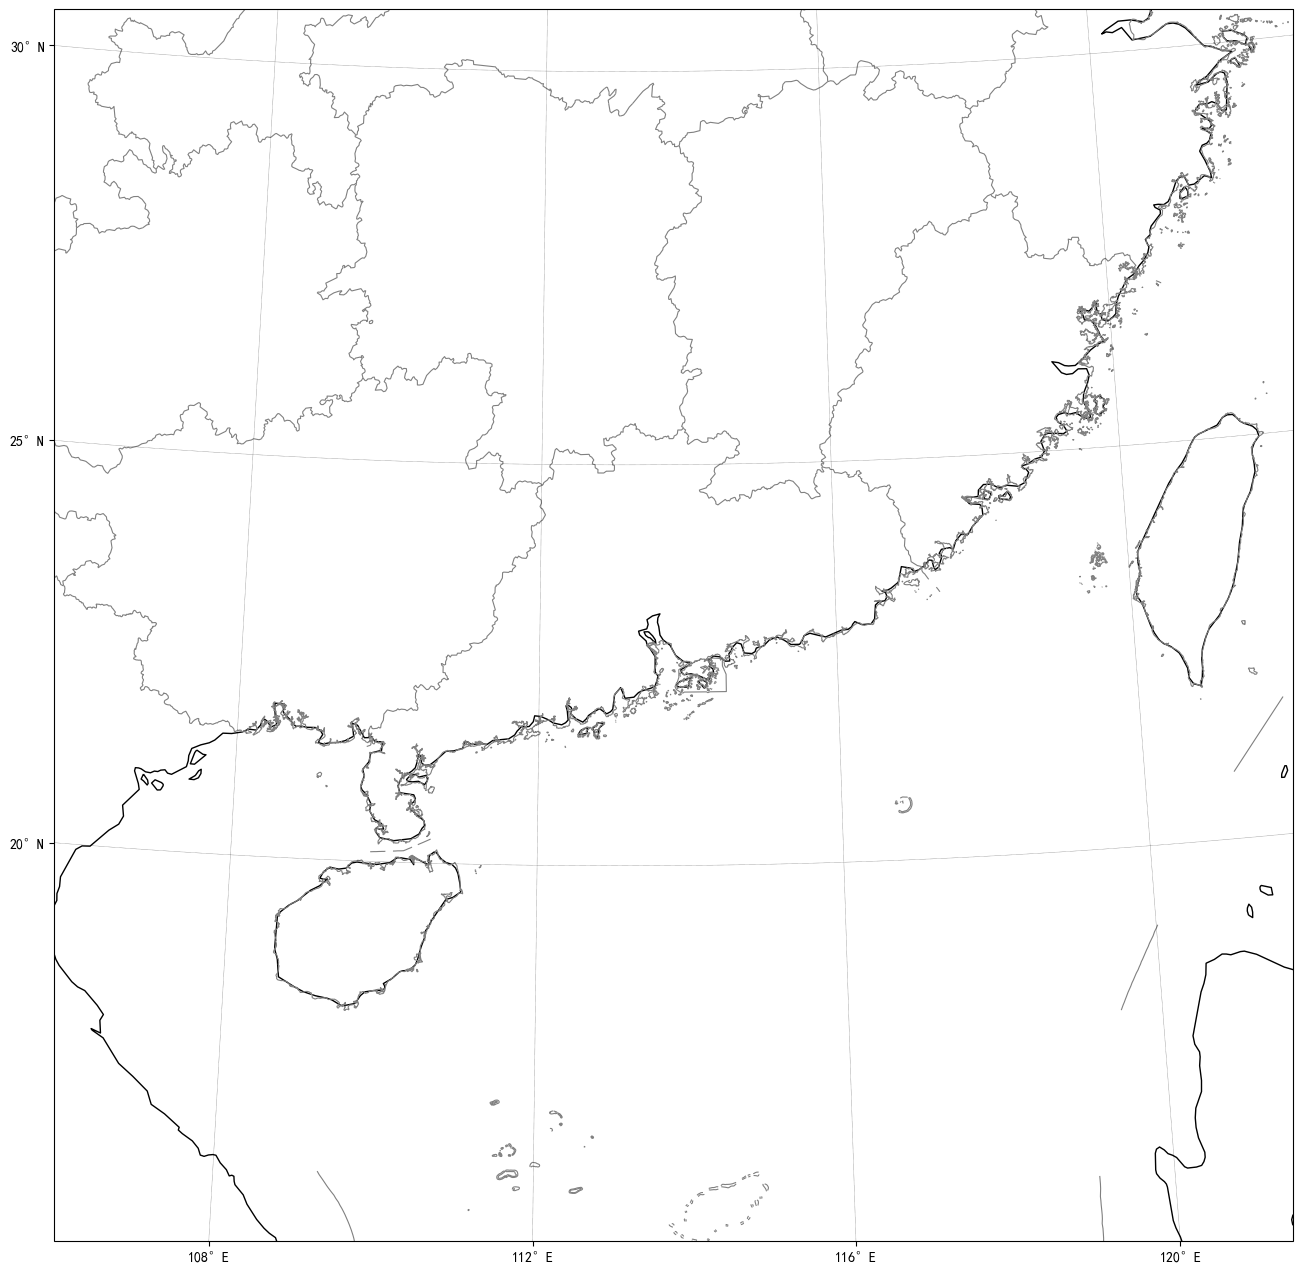

In [4]:
ax,fig=createmap()

<function lambert_yticks.<locals>.<lambda> at 0x0000018938E34F70>


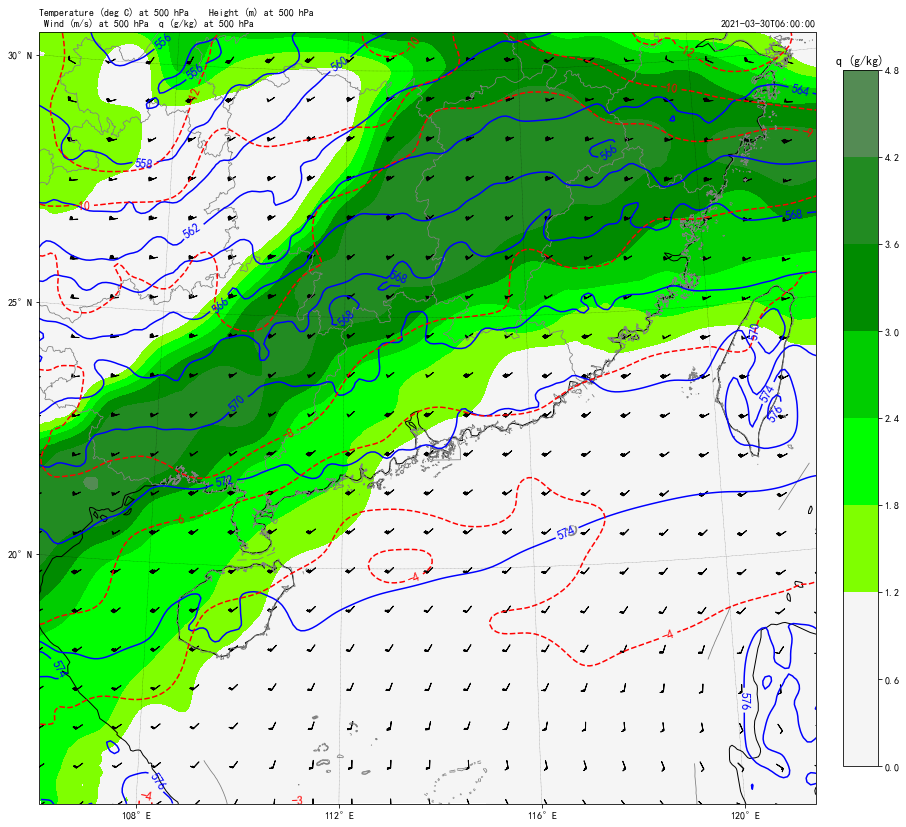

In [8]:
##  绘制500hPa 环流形势、风场、比湿场
ax,fig=createmap()
ax.set_title('Temperature (deg C) at 500 hPa    Height (m) at 500 hPa \n Wind (m/s) at 500 hPa  q (g/kg) at 500 hPa',fontdict={'fontsize':10},loc='left')
ax.set_title(str(hgt500['time'].data[0])[0:19],fontdict={'fontsize':10},loc='right')
# 绘图部分
## hgt
line=ax.contour(lon,lat,hgt500[0,:,:],levels=np.arange(520,600,2),colors='blue',transform=ccrs.PlateCarree())
ax.clabel(line, inline=True, fontsize=12, fmt='%.0f')
## T
line=ax.contour(lon,lat,T500[0,:,:],colors='r',transform=ccrs.PlateCarree())
ax.clabel(line, inline=True, fontsize=12, fmt='%.0f')
## q
colorbar=ax.contourf(lon,lat,q500[0,:,:]*1000,levels=[0,0.6,1.2,1.8,2.4,3,3.6,4.2,4.8],colors=['#f5f5f5','#f5f5f5','#7fff00','#00ff00','#00cd00','#008b00','#228b22','#548b54'],transform=ccrs.PlateCarree())
cb=fig.colorbar(colorbar,extendrect='True', pad=0.03, fraction=0.1, shrink=0.8)
cb.ax.set_title('q (g/kg)')
## wind
ax.barbs(np.array(lon)[::10,::10], np.array(lat)[::10,::10], np.array(u500[0,:,:])[::10,::10], np.array(v500[0,:,:])[::10,::10], pivot='middle', length=4, barb_increments=dict(half=2, full=4, flag=20),color='black', transform=ccrs.PlateCarree())

# fig.tight_layout()
plt.savefig('wrf500.png',dpi=500)

<function lambert_yticks.<locals>.<lambda> at 0x00000189380E03A0>


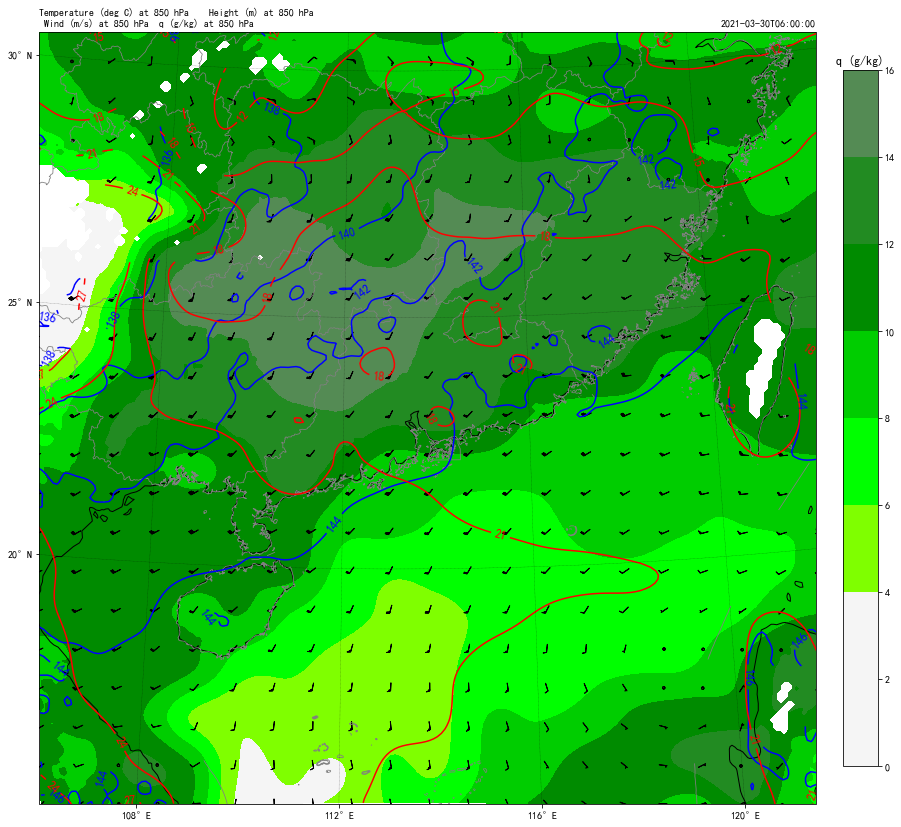

In [9]:
##  绘制850hPa 环流形势、风场、比湿场
ax,fig=createmap()
ax.set_title('Temperature (deg C) at 850 hPa    Height (m) at 850 hPa \n Wind (m/s) at 850 hPa  q (g/kg) at 850 hPa',fontdict={'fontsize':10},loc='left')
ax.set_title(str(hgt850['time'].data[0])[0:19],fontdict={'fontsize':10},loc='right')
# 绘图部分
## hgt
line=ax.contour(lon,lat,hgt850[0,:,:],levels=np.arange(120,180,2),colors='blue',transform=ccrs.PlateCarree())
ax.clabel(line, inline=True, fontsize=12, fmt='%.0f')
## T
line=ax.contour(lon,lat,T850[0,:,:],colors='r',transform=ccrs.PlateCarree())
ax.clabel(line, inline=True, fontsize=12, fmt='%.0f')
## q
colorbar=ax.contourf(lon,lat,q850[0,:,:]*1000,levels=[0,2,4,6,8,10,12,14,16],colors=['#f5f5f5','#f5f5f5','#7fff00','#00ff00','#00cd00','#008b00','#228b22','#548b54'],transform=ccrs.PlateCarree())
cb=fig.colorbar(colorbar,extendrect='True', pad=0.03, fraction=0.1, shrink=0.8)
cb.ax.set_title('q (g/kg)')
## wind
ax.barbs(np.array(lon)[::10,::10], np.array(lat)[::10,::10], np.array(u850[0,:,:])[::10,::10], np.array(v850[0,:,:])[::10,::10], pivot='middle', length=4, barb_increments=dict(half=2, full=4, flag=20),color='black', transform=ccrs.PlateCarree())

# fig.tight_layout()
plt.savefig('wrf850.png',dpi=500)

<function lambert_yticks.<locals>.<lambda> at 0x0000018938D04040>


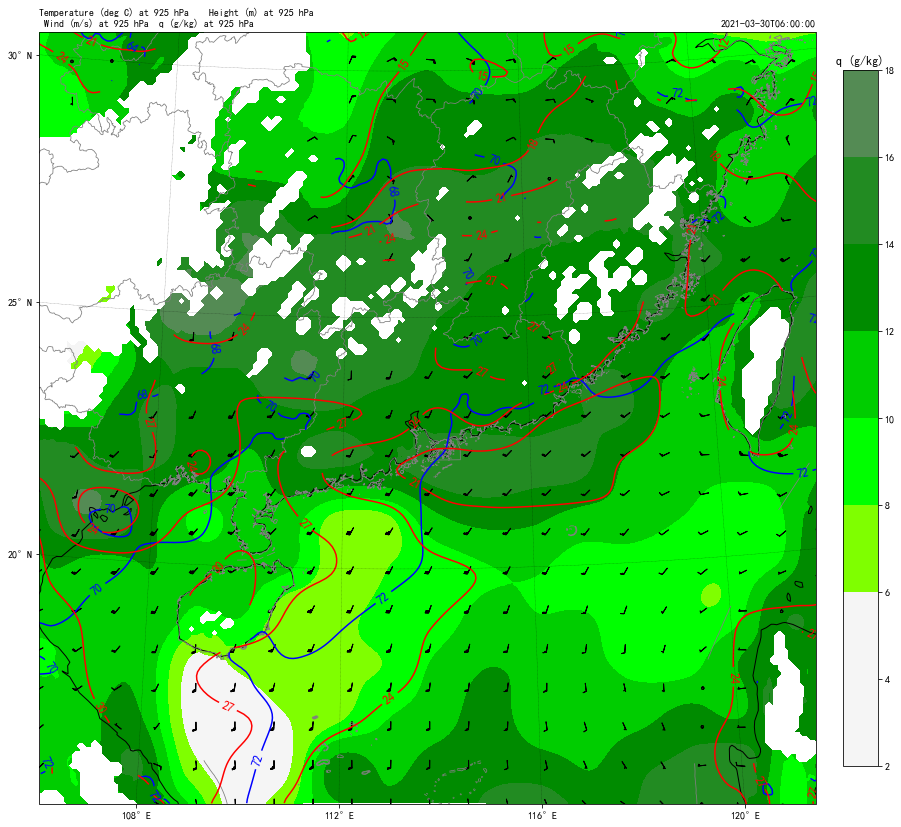

In [10]:
##  绘制925hPa 环流形势、风场、比湿场
ax,fig=createmap()
ax.set_title('Temperature (deg C) at 925 hPa    Height (m) at 925 hPa \n Wind (m/s) at 925 hPa  q (g/kg) at 925 hPa',fontdict={'fontsize':10},loc='left')
ax.set_title(str(hgt925['time'].data[0])[0:19],fontdict={'fontsize':10},loc='right')
# 绘图部分
## hgt ,
line=ax.contour(lon,lat,hgt925[0,:,:],levels=np.arange(0,180,2),colors='blue',transform=ccrs.PlateCarree())
ax.clabel(line, inline=True, fontsize=12, fmt='%.0f')
## T
line=ax.contour(lon,lat,T925[0,:,:],colors='r',transform=ccrs.PlateCarree())
ax.clabel(line, inline=True, fontsize=12, fmt='%.0f')
## q
colorbar=ax.contourf(lon,lat,q925[0,:,:]*1000,levels=[2,4,6,8,10,12,14,16,18],colors=['#f5f5f5','#f5f5f5','#7fff00','#00ff00','#00cd00','#008b00','#228b22','#548b54'],transform=ccrs.PlateCarree())
cb=fig.colorbar(colorbar,extendrect='True', pad=0.03, fraction=0.1, shrink=0.8)
cb.ax.set_title('q (g/kg)')
## wind
ax.barbs(np.array(lon)[::10,::10], np.array(lat)[::10,::10], np.array(u925[0,:,:])[::10,::10], np.array(v925[0,:,:])[::10,::10], pivot='middle', length=4, barb_increments=dict(half=2, full=4, flag=20),color='black', transform=ccrs.PlateCarree())

# fig.tight_layout()
plt.savefig('wrf925.png',dpi=500)